In [ ]:
import torch
import torch.nn as nn
import torch.optim as optim
import pennylane as qml
from pennylane import numpy as np
import numpy as npreal
import matplotlib.pyplot as plt

import wandb
import ndtest
from IPython.display import clear_output


In [ ]:
class Discriminator(nn.Module):
    def __init__(self, input_size, hid_size) -> None:
        """
        Args:
        - input_size (int): The size of the input data.
        - hid_size (int): The size of the hidden layers.
        """
        super().__init__()
        self.layers = nn.Sequential(
            nn.Linear(input_size, hid_size),
            nn.ReLU(),
            nn.Linear(hid_size, hid_size),
            nn.ReLU(),
            nn.Linear(hid_size, 1),
            nn.Sigmoid(),
        )

    def forward(self, x):
        """
        Performs a forward pass through the Discriminator.

        Args:
        - x (torch.Tensor): The input data.

        Returns:
        - torch.Tensor: The output of the Discriminator.
        """
        return self.layers(x)

    def fit_discriminator(self, x_data, criterion, net_G, optimizer, input_size):
        """
        Trains the Discriminator module.

        Args:
        - x_data (torch.Tensor): The real data.
        - criterion: The loss criterion.
        - net_G: The Generator network.
        - optimizer: The optimizer.
        - input_size (int): The size of the input data.

        Returns:
        - float: The loss value.

        """
        batch_size, _ = x_data.shape[0], x_data.shape[1]
        x_rand = 2*torch.rand((batch_size, input_size))-1

        self.zero_grad()

        # Forward pass Discriminator on "real" data
        labels_real = torch.ones((batch_size, 1)) * 0.9
        outputs = self.forward(x_data)
        loss_d_real = criterion(outputs, labels_real)

        # Forward pass Discriminator with "fake" data from Generator
        g = net_G(x_rand).detach() # Stop gradients from being updated in generator
        labels_fk = torch.zeros((batch_size, 1)) + 0.1
        outputs = self.forward(g)
        loss_d_fake = criterion(outputs, labels_fk)

        loss_d = loss_d_fake + loss_d_real
        loss_d.backward() # Compute Gradients
        optimizer.step() # Update Weights
        return loss_d.item()
    
number_of_qubits = 5
number_of_reps = 5

dev = qml.device('default.qubit', wires=number_of_qubits)

@qml.qnode(dev)
def quantum_generator(inputs, params):
    """
    Defines the quantum generator circuit. Embedding and Ansatz layers were based on the paper we followed.

    Args:
    - inputs (torch.Tensor): The input data.
    - params (torch.Tensor): The parameters of the circuit.

    Returns:
    - tuple: The probabilities of the qubits.
    """
    qml.AngleEmbedding(np.pi*inputs/2, rotation="Y", wires=range(number_of_qubits))
    num_params = 0
    for layer in range(number_of_reps):
        #initial RX,Ry,RZ gates.
        for i in range(number_of_qubits):
            qml.RX(params[num_params], wires=i)
            qml.RY(params[num_params+1], wires=i)
            qml.RZ(params[num_params+2], wires=i)
            num_params += 3

        # Entangling block
        for i in range(number_of_qubits):
            qml.CNOT(wires=[i, (i+1)%number_of_qubits])
    return qml.probs(wires=0), qml.probs(wires=1)

weights = {"params": 3 * number_of_qubits * number_of_reps}

class Generator(nn.Module):
    def __init__(self) -> None:
        super().__init__()
        self.q_gen = qml.qnn.TorchLayer(quantum_generator, weights)

    def forward(self, x):
        """
        Performs a forward pass through the Generator.

        Args:
        - x (torch.Tensor): The input data.

        Returns:
        - torch.Tensor: The output of the Generator.
        """
        out = (4/np.pi)*torch.arcsin(torch.sqrt(self.q_gen(x)))-1/2
        return out[:, [0, 2]]

    def fit_generator(self, net_D, batch_size, input_size, criterion, optimizer, code_dim, beta):  
        """
        Trains the Generator module.

        Args:
        - net_D: The Discriminator network.
        - T: The T network.
        - batch_size (int): The size of the batch.
        - input_size (int): The size of the input data.
        - criterion: The loss criterion.
        - optimizer: The optimizer.
        - code_dim (int): The dimension of the code.
        - beta (float): The beta value.

        Returns:
        - float: The loss value.
        """
        x_rand = 2*torch.rand((batch_size, input_size))-1
        self.zero_grad()
        
        # Generate outputs With Generator and check if they fool Discriminator
        labels_real = torch.ones((batch_size, 1)) * 0.9
        g = self.forward(x_rand)
        outputs = net_D(g)

        loss_g = criterion(outputs, labels_real) # We want "fake" Generator output to look real  
        loss_g.backward()
        optimizer.step()
        
        return loss_g.item()

In [ ]:
N_points = 2000 # From paper

np.random.seed(0)

x = np.random.uniform(low=0.25, high=0.75, size=N_points)
y = np.random.uniform(low=0.25, high=0.75, size=N_points)

# Plot the data
plt.figure(figsize=(4, 4))
plt.scatter(x, y, alpha=1, s=10)
plt.xlim(0, 1)
plt.ylim(0, 1)
plt.xlabel('x')
plt.ylabel('y')
plt.title("Central Square Distribution (2000 points)")
plt.gca().set_aspect('equal', adjustable='box')  # Make the plot square
plt.legend()
plt.show()

In [ ]:
from torch.utils.data import Dataset, DataLoader

class XYDistribution(Dataset):
    def __init__(self, x, y):
        self.x = torch.tensor(x, dtype=torch.float32)
        self.y = torch.tensor(y, dtype=torch.float32)
        
    def __len__(self):
        return len(self.x)
    
    def __getitem__(self, idx):
        return torch.stack((self.x[idx], self.y[idx]))

In [ ]:
def boundary_adherence(points, center=(0.5, 0.5), side_length=0.5):
    """
    Calculates the adherence rate of points within a specified boundary.

    Parameters:
    - points (numpy.ndarray): Array of points with shape (n, 2), where n is the number of points.
    - center (tuple, optional): Center coordinates of the boundary. Default is (0.5, 0.5).
    - side_length (float, optional): Length of the side of the boundary. Default is 0.5.

    Returns:
    - adherence_rate (float): The percentage of points that fall within the boundary.
    """
    x_min, y_min = center[0] - side_length / 2, center[1] - side_length / 2
    x_max, y_max = center[0] + side_length / 2, center[1] + side_length / 2

    within_bounds = ((points[:, 0] >= x_min) & (points[:, 0] <= x_max) &
                     (points[:, 1] >= y_min) & (points[:, 1] <= y_max))
    adherence_rate = np.mean(within_bounds) * 100  # Convert to percentage
    return adherence_rate

# Plot test data
def plot_xy(x_pts, y_pts):
    plt.figure(figsize=(4, 4))
    plt.scatter(x_pts, y_pts, alpha=1, s=10)
    plt.xlim(0, 1)
    plt.ylim(0, 1)
    plt.xlabel('x')
    plt.ylabel('y')
    plt.title("Test Generator Output")
    plt.gca().set_aspect('equal', adjustable='box')  # Make the plot square
    plt.legend()
    plt.show()
    return plt.figure()

In [ ]:
noise_size = 3
code_size = 2
beta = 0.1

net_D = Discriminator(2, 86)
net_G = Generator()

batch_size = 80

dataset = XYDistribution(x, y)
dataloader = DataLoader(dataset, batch_size=batch_size)

criterion = nn.BCELoss()

# Create batch of latent vectors that we will use to visualize
#  the progression of the generator
fixed_noise = 2*torch.rand(1000, noise_size + code_size)-1

lrd = 0.0003
lrg = 0.001
lrt = 0.001
gamma_d = 0.85
gamma_g = 0.7
gamma_t = 0.7

optimizer_D = optim.Adam(net_D.parameters(), lr=lrd)
scheduler_D = optim.lr_scheduler.ExponentialLR(optimizer_D, gamma=gamma_d)
optimizer_G = optim.Adam(net_G.parameters(), lr=lrg)
scheduler_G = optim.lr_scheduler.ExponentialLR(optimizer_D, gamma=gamma_g)

In [ ]:
d_error = []
g_error = []
t_error = []
fk_prog = []
best_p_value = -99

wandb.init(
    project='InfoQGAN',
    group='QGan_square',
    config = {
        "Generator Architecture": str(dict(net_G.named_modules())),
        "Discriminator Architecture": str(dict(net_D.named_modules())),
        "Batch Size": batch_size
    }
)

for _ in range(300):
    for batch in dataloader:
        # First Update Discriminator with batch of Real Data
        d_loss = net_D.fit_discriminator(batch, criterion, net_G, optimizer_D, noise_size+code_size)
        g_loss = net_G.fit_generator(net_D, batch_size, noise_size+code_size, criterion, optimizer_G, code_size, beta)

        # print("Batch done")
        d_error.append(d_loss)
        g_error.append(g_loss)
        wandb.log({"d_loss": d_loss, "g_loss": g_loss})
    
    print("Epoch: ", _)
    with torch.no_grad():
        fake = net_G(fixed_noise)
        # print(fake.size())
        acc = boundary_adherence(fake.detach().numpy())
        P, D = ndtest.ks2d2s(x, y, fake[:, 0].detach().numpy(), fake[:, 1].detach().numpy(), extra=True)
        # if P > best_p_value:
        #     best_p_value = P
        #     torch.save(compiled_G.state_dict(), f'./models/run_72/pval{P}.pth')
        wandb.log({"Accuracy": acc, "KS Test p-value": P, "KS Test value": D})
        x_c1 = npreal.cov(fake[:, 0].detach().numpy(), fixed_noise[:, 0])[0][1]
        x_c2 = npreal.cov(fake[:, 0].detach().numpy(), fixed_noise[:, 1])[0][1]
        y_c1 = npreal.cov(fake[:, 1].detach().numpy(), fixed_noise[:, 0])[0][1]
        y_c2 = npreal.cov(fake[:, 1].detach().numpy(), fixed_noise[:, 1])[0][1]
        # print(x_c1)
        wandb.log({"Code 0 - X axis": x_c1, "Code 1 - X axis": x_c2, "Code 0 - Y axis": y_c1, "Code 1 - Y axis": y_c2})
        # print(P)

    if _ % 5 == 0:
        with torch.no_grad():
            fake = net_G(fixed_noise)
            clear_output(wait=True)
            fig = plot_xy(fake[:, 0].detach().numpy(), fake[:, 1].detach().numpy())
            # img = wandb.Image(fig)
            # wandb.log({"Generator Output": img})

#wandb.finish()

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


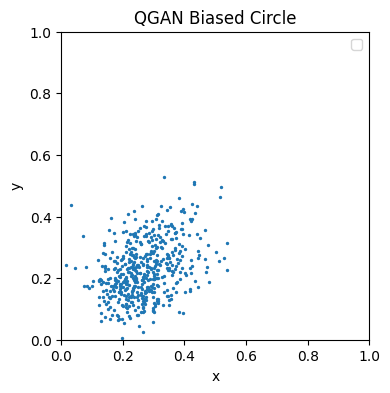

<Figure size 640x480 with 0 Axes>

In [18]:
def plot_xy(x_pts, y_pts):
    plt.figure(figsize=(4, 4))
    plt.scatter(x_pts, y_pts, alpha=1, s=2)
    plt.xlim(0, 1)
    plt.ylim(0, 1)
    plt.xlabel('x')
    plt.ylabel('y')
    plt.title("QGAN Biased Circle")
    plt.gca().set_aspect('equal', adjustable='box')  # Make the plot square
    plt.legend()
    plt.show()
    return plt.figure()
fake = net_G(fixed_noise)
fig = plot_xy(fake[:, 0].detach().numpy(), fake[:, 1].detach().numpy())

In [ ]:
wandb.finish()

In [ ]:
torch.save(net_G.state_dict(), './models/swift-brook-77.pth')

In [ ]:
rand_inp = 2*torch.rand((1000, 5))-1

gen_output = net_G(rand_inp)

x_test = gen_output[:, 0].detach().numpy()
y_test = gen_output[:, 1].detach().numpy()

# Plot test data
def plot_xy_codes(x_pts, y_pts, code_index):
    plt.figure(figsize=(4, 4))
    plt.scatter(x_pts, y_pts, c=rand_inp[:, code_index], cmap='coolwarm', alpha=1, s=10)
    plt.xlim(0, 1)
    plt.ylim(0, 1)
    plt.xlabel('x')
    plt.ylabel('y')
    plt.title(f"QGAN Feature Sep. for Code {code_index}")
    plt.gca().set_aspect('equal', adjustable='box')  # Make the plot square
    plt.legend()
    plt.colorbar(label='Code Value')
    plt.show()

plot_xy_codes(gen_output[:, 0].detach().numpy(), gen_output[:, 1].detach().numpy(), 0)

In [ ]:
plot_xy_codes(gen_output[:, 0].detach().numpy(), gen_output[:, 1].detach().numpy(), 1)

In [ ]:
def plot_xy_overlaid(x_pts, y_pts):
    plt.figure(figsize=(4, 4))
    plt.scatter(x, y, alpha=1, s=2, label='Target Distribution')
    plt.scatter(x_pts, y_pts, alpha=1, s=2, label='QGAN')
    
    plt.xlim(0, 1)
    plt.ylim(0, 1)
    plt.xlabel('x')
    plt.ylabel('y')
    plt.title("QGAN Central Square")
    plt.gca().set_aspect('equal', adjustable='box')  # Make the plot square
    plt.legend()
    plt.show()
    return plt.figure()
plot_xy_overlaid(x_test, y_test)

### Biased Circle

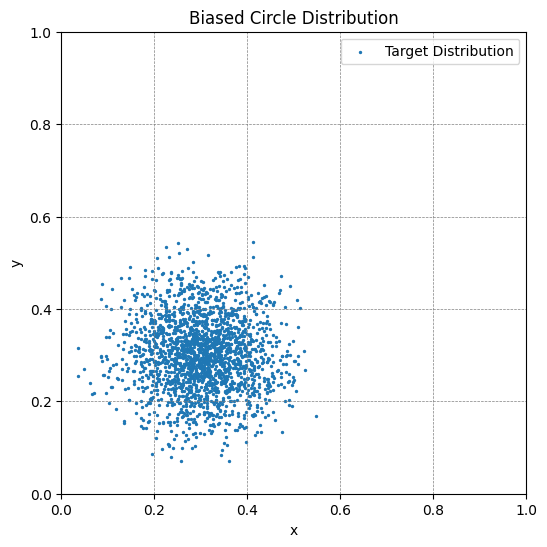

In [11]:
# Set random seed for reproducibility
np.random.seed(0)

def generate_biased_circle(num_points):
    # Generate random angles
    theta = np.random.uniform(0, 2 * np.pi, num_points)
    
    # Generate a bias in the radius
    r = np.random.beta(a=2, b=4, size=num_points)

    # Convert polar to Cartesian coordinates
    x = r * np.cos(theta)
    y = r * np.sin(theta)

    # Apply a transformation to bias the distribution toward one side of the circle
    x_bias = 0.3  # Adjust this value to control the direction of the bias
    y_bias = 0.3  # Adjust this value to control the direction of the bias
    x = x * x_bias + 0.3
    y = y * y_bias + 0.3

    return x, y

# Generate 2000 points with biased circle distribution
x, y = generate_biased_circle(2000)

# Plotting the biased circle on a 1 by 1 square
plt.figure(figsize=(6, 6))
plt.scatter(x, y, label='Target Distribution', s=2)
plt.xlim(0, 1)  # Set x-axis range from 0 to 1
plt.ylim(0, 1)  # Set y-axis range from 0 to 1
plt.xlabel('x')
plt.ylabel('y')
plt.title('Biased Circle Distribution')
plt.legend()

# Add grid lines
plt.grid(linewidth=0.5, color='gray', linestyle='--')

# Set grid lines every 0.2 in both directions
plt.xticks(np.arange(0, 1.2, 0.2))
plt.yticks(np.arange(0, 1.2, 0.2))

plt.show()

In [12]:

noise_size = 3
code_size = 2
beta = 0.5

net_D = Discriminator(2, 86)
# compiled_D = torch.compile(net_D,mode='default')
compiled_D = net_D
net_G = Generator()
compiled_G = net_G
# compiled_G = torch.compile(net_G.forward,mode='default')

batch_size = 80

dataset = XYDistribution(x, y)
dataloader = DataLoader(dataset, batch_size=batch_size)

criterion = nn.BCELoss()

# Create batch of latent vectors that we will use to visualize
#  the progression of the generator
fixed_noise = 2*torch.rand(500, noise_size + code_size)-1

lrd = 0.0003
lrg = 0.001
lrt = 0.001
gamma_d = 0.85
gamma_g = 0.7
gamma_t = 0.7

optimizer_D = optim.Adam(compiled_D.parameters(), lr=lrd)
scheduler_D = optim.lr_scheduler.StepLR(optimizer_D, gamma=gamma_d, step_size=30)
optimizer_G = optim.Adam(compiled_G.parameters(), lr=lrg)
scheduler_G = optim.lr_scheduler.StepLR(optimizer_G, gamma=gamma_g, step_size=30)

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


<Figure size 640x480 with 0 Axes>

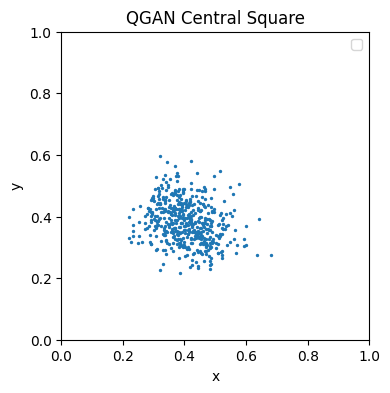

Epoch:  281
Epoch:  282
Epoch:  283
Epoch:  284
Epoch:  285
Epoch:  286
Epoch:  287
Epoch:  288
Epoch:  289
Epoch:  290
Epoch:  291
Epoch:  292
Epoch:  293
Epoch:  294
Epoch:  295
Epoch:  296
Epoch:  297
Epoch:  298
Epoch:  299


Accuracy,▇▄▃▄▄▅▄▅▄▃▃▂▄▅█▂▂▅▁▅▄▁▅▂▃▃▃▃▂▃▇▂▄▂▃▆▃▅▅▁
Code 0 - X axis,▆█▄▃▁▁▃▃▃▅▃▅▆▃█▅▅▄▅▄▄▅▄▆▃▆▃▆▄▅▄▄▄▅▅▆▅▆▆▇
Code 0 - Y axis,▁▄▄▆▇▇▇▇▇▇▇▇▇▆█▇▇▆▇▆▆▇▆▇▆▇▆█▇▆▆▇▅█▇█▇▇▅▅
Code 1 - X axis,▄█▇▇▅▄▅▅▅▅▇▅▆▄▂█▇▁▆▂▃▆▂▆▄▆▅▄▆▄▃▅▃▆▅▄▅▄▃▆
Code 1 - Y axis,▄▁▂▄▅▅▅▅▅▅▅▅▅▅▆▄▅▅▅▅▅▅▆▅▆▆▆▇▅▆▇▅▇▆▆▇▆▇█▇
KS Test p-value,▁▁▁▅█▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
KS Test value,█▃▂▁▁▂▃▃▃▄▂▆▁▅█▄▅█▇▇▆▇▅▆▄▅▄█▅▄▄▅▆▆▃▆▃▂█▅
d_loss,▁▅▄▄▆▄▅▄▆▅▆▅▅▆█▅▆▆▆▆▅▅▅▅▅▆▅▅▄▆▆▅▅▅▅▅▅▅█▅
g_loss,█▂▄▆▄▃▄▄▂▄▂▃▃▂▃▂▂▂▃▂▃▃▄▂▃▂▂▃▃▁▂▃▃▄▃▃▃▃▁▂
Accuracy,26.0
Code 0 - X axis,0.00465


<Figure size 640x480 with 0 Axes>

In [13]:
d_error = []
g_error = []
t_error = []
fk_prog = []
best_p_value = -99

wandb.init(
    project='InfoQGAN',
    group='QGan_square',
    config = {
        "Generator Architecture": str(dict(net_G.named_modules())),
        "Discriminator Architecture": str(dict(net_D.named_modules())),
        "Batch Size": batch_size
    }
)

for _ in range(300):
    for batch in dataloader:
        # First Update Discriminator with batch of Real Data
        d_loss = net_D.fit_discriminator(batch, criterion, net_G, optimizer_D, noise_size+code_size)
        g_loss = net_G.fit_generator(net_D, batch_size, noise_size+code_size, criterion, optimizer_G, code_size, beta)

        # print("Batch done")
        d_error.append(d_loss)
        g_error.append(g_loss)
        wandb.log({"d_loss": d_loss, "g_loss": g_loss})
    
    print("Epoch: ", _)
    with torch.no_grad():
        fake = net_G(fixed_noise)
        # print(fake.size())
        acc = boundary_adherence(fake.detach().numpy())
        P, D = ndtest.ks2d2s(x, y, fake[:, 0].detach().numpy(), fake[:, 1].detach().numpy(), extra=True)
        # if P > best_p_value:
        #     best_p_value = P
        #     torch.save(compiled_G.state_dict(), f'./models/run_72/pval{P}.pth')
        wandb.log({"Accuracy": acc, "KS Test p-value": P, "KS Test value": D})
        x_c1 = npreal.cov(fake[:, 0].detach().numpy(), fixed_noise[:, 0])[0][1]
        x_c2 = npreal.cov(fake[:, 0].detach().numpy(), fixed_noise[:, 1])[0][1]
        y_c1 = npreal.cov(fake[:, 1].detach().numpy(), fixed_noise[:, 0])[0][1]
        y_c2 = npreal.cov(fake[:, 1].detach().numpy(), fixed_noise[:, 1])[0][1]
        # print(x_c1)
        wandb.log({"Code 0 - X axis": x_c1, "Code 1 - X axis": x_c2, "Code 0 - Y axis": y_c1, "Code 1 - Y axis": y_c2})
        # print(P)

    if _ % 20 == 0:
        with torch.no_grad():
            fake = net_G(fixed_noise)
            clear_output(wait=True)
            fig = plot_xy(fake[:, 0].detach().numpy(), fake[:, 1].detach().numpy())
            # img = wandb.Image(fig)
            # wandb.log({"Generator Output": img})

wandb.finish()

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


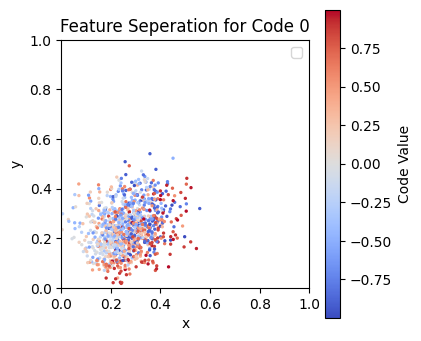

In [15]:
rand_inp = 2*torch.rand((1000, 5))-1
# m = Generator()
# m.load_state_dict(torch.load('./models/run_67/pval0.20862903252000067.pth'))

gen_output = compiled_G(rand_inp)

x_test = gen_output[:, 0].detach().numpy()
y_test = gen_output[:, 1].detach().numpy()

# Plot test data
def plot_xy_codes(x_pts, y_pts, code_index):
    plt.figure(figsize=(4, 4))
    plt.scatter(x_pts, y_pts, c=rand_inp[:, code_index], cmap='coolwarm', alpha=1, s=2)
    plt.xlim(0, 1)
    plt.ylim(0, 1)
    plt.xlabel('x')
    plt.ylabel('y')
    plt.title(f"Feature Seperation for Code {code_index}")
    plt.gca().set_aspect('equal', adjustable='box')  # Make the plot square
    plt.legend()
    plt.colorbar(label='Code Value')
    plt.show()

plot_xy_codes(gen_output[:, 0].detach().numpy(), gen_output[:, 1].detach().numpy(), 0)

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


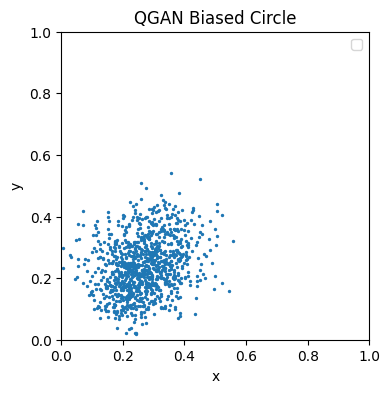

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

In [19]:
plot_xy(x_test, y_test)